In [1]:
#Importing necessary libraries
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from PIL import Image
from PIL import Image, ImageChops, ImageEnhance
from sklearn.utils import shuffle
import tensorflow as tf
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
au_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Au'
tp_path = '/kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/Tp'

au_data = {'image_id': [],'image_path': [],'label': []}
tp_data = {'image_id': [],'image_path': [],'label': []}

for img in os.listdir(au_path):
    if img.endswith('jpg') or img.endswith('png'):
        temp_path = os.path.join(au_path, img)
        au_data['image_id'].append(img.split("_")[2].split('.')[0])
        au_data['image_path'].append(temp_path)
        au_data['label'].append('real')

for img in os.listdir(tp_path):
    if img.endswith('jpg') or img.endswith('png'):
        temp_path = os.path.join(tp_path, img)
        tp_data['image_path'].append(temp_path)
        tp_data['label'].append('fake')
        tp_data['image_id'].append(img.split('_')[7].split('.')[0])
    
    
        
au_data = pd.DataFrame(au_data)
tp_data = pd.DataFrame(tp_data)

casia_data = pd.concat([au_data, tp_data], ignore_index=True)
casia_data = casia_data.sample(frac=1, random_state=random.seed(42)).reset_index(drop=True)
casia_data.head()

,image_id,image_path,label
0,11262,/kaggle/input/casia-20-image-tampering-detecti...,fake
1,30204,/kaggle/input/casia-20-image-tampering-detecti...,real
2,11896,/kaggle/input/casia-20-image-tampering-detecti...,fake
3,30132,/kaggle/input/casia-20-image-tampering-detecti...,real
4,00016,/kaggle/input/casia-20-image-tampering-detecti...,real


In [5]:

def convert_to_ela_image(path, quality):
    temp_filename = 'temp.jpg'
    
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

In [6]:
image_size = (128, 128)

def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 85).resize(image_size)).flatten() / 255.0

In [7]:
X=[]
Y=[]
for index,rows in tqdm(casia_data.iterrows()) :
    temp_ela_image=prepare_image(rows['image_path'])
    X.append(temp_ela_image)
    if rows['label']=='fake' :
        Y.append(0)
    else :
        Y.append(1)

9501it [02:44, 57.60it/s]


In [8]:
X, Y = shuffle(X, Y, random_state=42)
X = np.array(X)
X = X.reshape(-1, 128, 128, 3)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=42)

In [9]:
class Dataset:
    def __init__(self, data_x,data_y):
        self.x = []
        self.y = []
        
        for img in data_x :
            self.x.append(img)
        
        for lab in data_y :
            self.y.append(lab)
            

    def __getitem__(self, i):
            
        return self.x[i],self.y[i]
        

    def __len__(self): # your model.fit_gen requires this function
        return len(self.x)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1,shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.indexes = np.arange(len(self.dataset.x))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        #batch = [for samples in zip(*data)]
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple([batch[0],batch[1]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

train_dataset=Dataset(X_train,Y_train)
train_dataloader = Dataloder(train_dataset, batch_size=8,shuffle=True)

test_dataset=Dataset(X_val,Y_val)
test_dataloader = Dataloder(test_dataset, batch_size=8,shuffle=True)


In [10]:
from keras.layers import Input
from keras.models import Model

Input_shape=Input(shape=(128,128,3))
conv11=Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu")(Input_shape)
conv12=Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(conv11)
conv13=MaxPool2D(pool_size=(2,2),strides=(2,2))(conv12)
conv13=Dropout(0.3)(conv13)


flatten1=Flatten()(conv13)
dense1=Dense(units=16,activation="relu")(flatten1)
dense2=Dense(units=8,activation="relu")(dense1)
output=Dense(units=1, activation="sigmoid")(dense2)

model=Model(inputs=Input_shape,outputs=output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      73792     
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                             

In [11]:
model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [12]:
#Callbacks 
def scheduler(epoch,lr) :
  if epoch%5==0 :
    lr=0.9*lr
  
  return lr
lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
es=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3)
rl=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=5)

In [13]:
model.fit(train_dataloader,steps_per_epoch=len(train_dataloader)//8,validation_data=test_dataloader,validation_steps=len(test_dataloader)//8,epochs=30,callbacks=[lrScheduler,es,rl])

Epoch 1/30


2023-11-29 18:37:02.224386: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


118/118 [==============================] - 19s 26ms/step - loss: 0.4638 - accuracy: 0.7775 - val_loss: 0.3869 - val_accuracy: 0.8017 - lr: 9.0000e-05
Epoch 2/30
118/118 [==============================] - 3s 24ms/step - loss: 0.3825 - accuracy: 0.7754 - val_loss: 0.3629 - val_accuracy: 0.8017 - lr: 9.0000e-05
Epoch 3/30
118/118 [==============================] - 3s 24ms/step - loss: 0.3415 - accuracy: 0.7871 - val_loss: 0.3703 - val_accuracy: 0.7974 - lr: 9.0000e-05
Epoch 4/30
118/118 [==============================] - 3s 24ms/step - loss: 0.3206 - accuracy: 0.8040 - val_loss: 0.3324 - val_accuracy: 0.8147 - lr: 9.0000e-05
Epoch 5/30
118/118 [==============================] - 3s 23ms/step - loss: 0.3171 - accuracy: 0.8104 - val_loss: 0.3438 - val_accuracy: 0.8190 - lr: 9.0000e-05
Epoch 6/30
118/118 [==============================] - 3s 24ms/step - loss: 0.3315 - accuracy: 0.7913 - val_loss: 0.3245 - val_accuracy: 0.8448 - lr: 8.1000e-05
Epoch 7/30
118/118 [==============================

In [14]:
model.save('phase1.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
pred = model.predict(test_dataloader)
y_pred = (pred >= 0.5).astype(int)
y_pred = y_pred.flatten()
y_pred = y_pred.tolist()
y_true = test_dataloader.dataset.y
y_true = y_true[:-5]

237/237 [==============================] - 1s 5ms/step


Accuracy : 0.9209
Precision : 0.9716
Recall : 0.9278
F1 Score : 0.9492



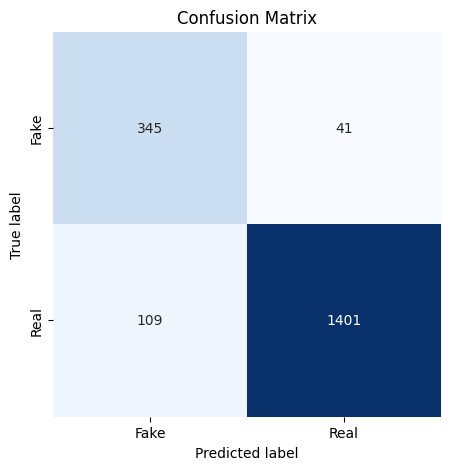

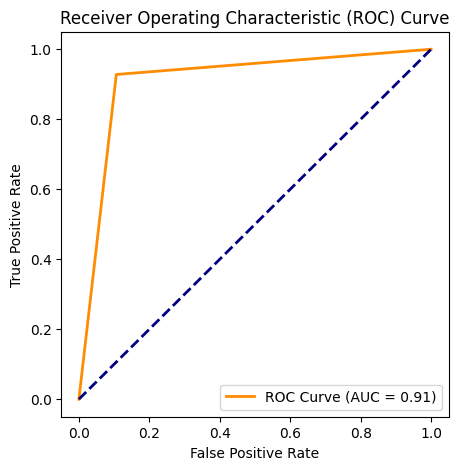

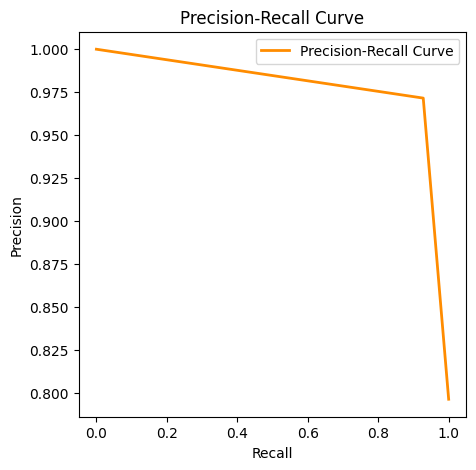

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)


print(f"Accuracy : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print()

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(5, 5))
plt.plot(recall, precision, color='darkorange', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()



In [45]:
def predict(img_path,model) :
    pi=prepare_image(img_path)
    pi=pi.reshape(1,128,128,3)
    predict=model.predict(pi)
    return predict

In [47]:
#Prediction on 5 random images 
for i in range(1,6) :
  ran_num=np.random.randint(0,casia_data.shape[0])
  temp_row=casia_data.iloc[ran_num,:]
  print("="*100)
  temp_arr=plt.imread(temp_row['image_path'])
  print("Real label--- {}".format(temp_row['label']))
  temp_predict=predict(temp_row['image_path'],model)
  if temp_predict[0]>0.5 :
    temp_prediction='real'
  else:
    temp_prediction='fake'
  print("Predicted label--- {}".format(temp_prediction))


Real label--- real
1/1 [==============================] - 0s 210ms/step
Predicted label--- real
Real label--- real
1/1 [==============================] - 0s 19ms/step
Predicted label--- real
Real label--- real
1/1 [==============================] - 0s 19ms/step
Predicted label--- real
Real label--- fake
1/1 [==============================] - 0s 20ms/step
Predicted label--- real
Real label--- real
1/1 [==============================] - 0s 20ms/step
Predicted label--- real
